In [6]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Constants
max_len = 130
num_features_per_timestep = 13  # Number of MFCC features per timestep

# === Step 1: Load dataset
df = pd.read_csv("ravdess_all_actors_full_mfcc.csv")
df = df[df["emotion"] != "unknown"].reset_index(drop=True)

# === Step 2: Prepare features and labels
feature_columns = [col for col in df.columns if col.startswith("mfcc_")]
X = df[feature_columns].values
y = df['emotion'].values

# === Step 3: Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# === Step 4: Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Shape of X before scaling:", X.shape)
print("Expected: num_samples × num_features")


# === Step 5: Reshape input to (samples, timesteps, features)

X_reshaped = X_scaled.reshape(X_scaled.shape[0], 130, 13)


# === Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

# === Step 7: Class Weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = dict(enumerate(class_weights))

# === Step 8: CNN + BiLSTM Model
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(max_len, num_features_per_timestep)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# === Step 9: Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

# === Step 10: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# === Step 11: Save model and label encoder
model.save("speech_emotion_cnn_bilstm.h5")
encoder_df = pd.DataFrame({'label': encoder.classes_})
encoder_df.to_csv("label_encoder.csv", index=False)

print("✅ Model saved as speech_emotion_cnn_bilstm.h5")


Shape of X before scaling: (2880, 1690)
Expected: num_samples × num_features
Epoch 1/100
Epoch 1/100
72/72 [==============================] - 13s 89ms/step - loss: 1.8636 - accuracy: 0.2457 - val_loss: 1.7225 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 13s 89ms/step - loss: 1.8636 - accuracy: 0.2457 - val_loss: 1.7225 - val_accuracy: 0.3420 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 5s 64ms/step - loss: 1.6587 - accuracy: 0.3429 - val_loss: 1.5961 - val_accuracy: 0.3819 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 5s 64ms/step - loss: 1.6587 - accuracy: 0.3429 - val_loss: 1.5961 - val_accuracy: 0.3819 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 4s 60ms/step - loss: 1.5500 - accuracy: 0.4041 - val_loss: 1.4203 - val_accuracy: 0.4635 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 4s 60ms/step - loss: 1.5500 - accuracy: 0.4041 - val_loss: 1.4203 - val_accuracy:

In [7]:
import pickle
#...existing code...
# After fitting encoder and scaler, save them for use in testing
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

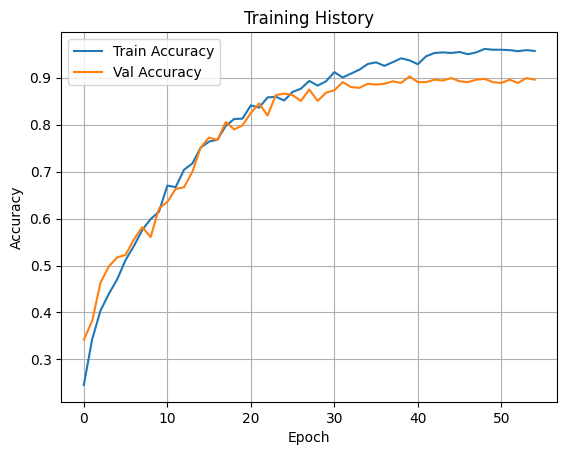

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=encoder.classes_))

18/18 [==============================] - 0s 22ms/step - loss: 0.4399 - accuracy: 0.8993
Test Accuracy: 89.93%
Test Accuracy: 89.93%
18/18 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

       angry       0.83      0.92      0.88        76
        calm       0.86      0.92      0.89        77
     disgust       0.90      0.90      0.90        77
     fearful       0.94      0.87      0.91        77
       happy       0.87      0.90      0.88        77
     neutral       1.00      1.00      1.00        38
         sad       0.91      0.79      0.85        77
   surprised       0.95      0.95      0.95        77

    accuracy                           0.90       576
   macro avg       0.91      0.91      0.91       576
weighted avg       0.90      0.90      0.90       576

              precision    recall  f1-score   support

       angry       0.83      0.92      0.88        76
        calm       0.86      0.92      0.89        77
